### 📌 EXTRAÇÃO E CONFIGURAÇÃO DOS DADOS

Este notebook apresenta uma análise de churn (evasão de clientes) da empresa TelecomX_BR, através da extração e configuração dos dados de uma API, com o objetivo de identificar padrões nos dados de clientes que cancelaram os serviços e fornecer recomendações para ajudar na retenção de usuários.

In [13]:
# Importação de bibliotecas
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests

# Configuração de visualização
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

api_url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/main/TelecomX_Data.json"

response = requests.get(api_url)

data = response.json()

df = pd.json_normalize(data)

### Transformação dos Dados

Nesta etapa, foi realizado a limpeza, normalização e conversão de tipos para garantir uma base de dados confiável para a análise.


In [14]:
# Renomear colunas para remover prefixos
df.columns = [col.replace("customer.", "").replace("phone.", "").replace("internet.", "").replace("account.", "").replace("Charges.", "Charges_") for col in df.columns]

# Conversões e limpeza
df['Charges_Total'] = pd.to_numeric(df['Charges_Total'], errors='coerce')
df['Churn'] = df['Churn'].replace('', np.nan)
df = df.dropna(subset=['Churn'])

# Padronizar categorias
cols_padronizar = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','MultipleLines']
for col in cols_padronizar:
    if col in df.columns:
        df[col] = df[col].replace({'No internet service': 'No', 'No phone service': 'No'})

# Converter variáveis binárias
binarias = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binarias:
    if col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].map({'Yes': 1, 'No': 0})
df_final = df.copy()


### 📊 Carga e análise

Taxa de churn (%): 26.54


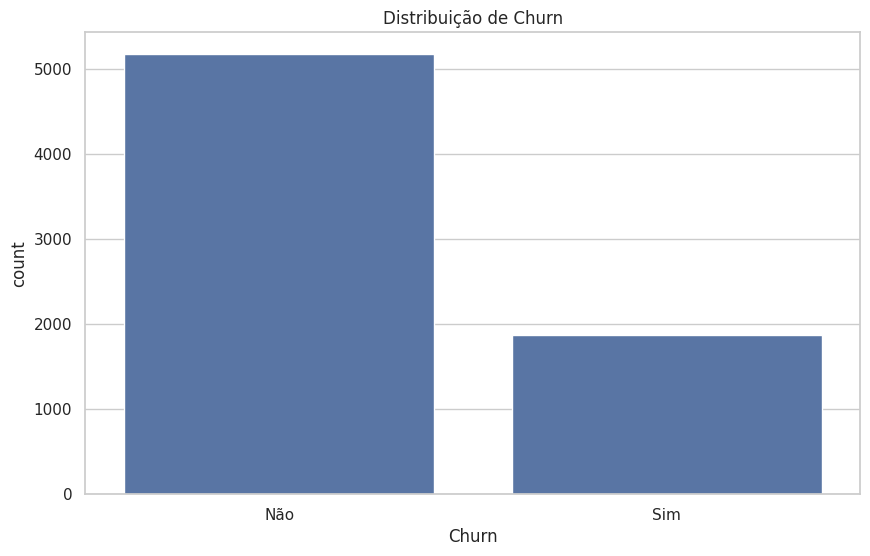

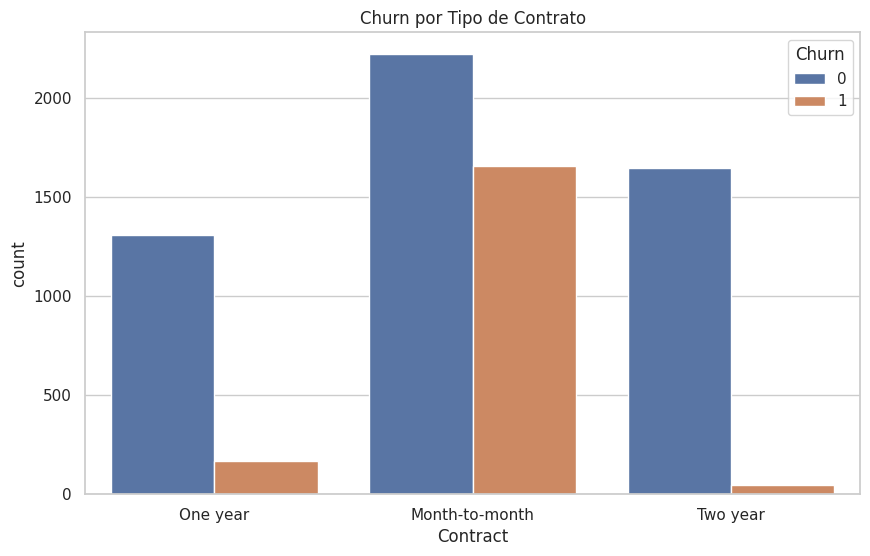

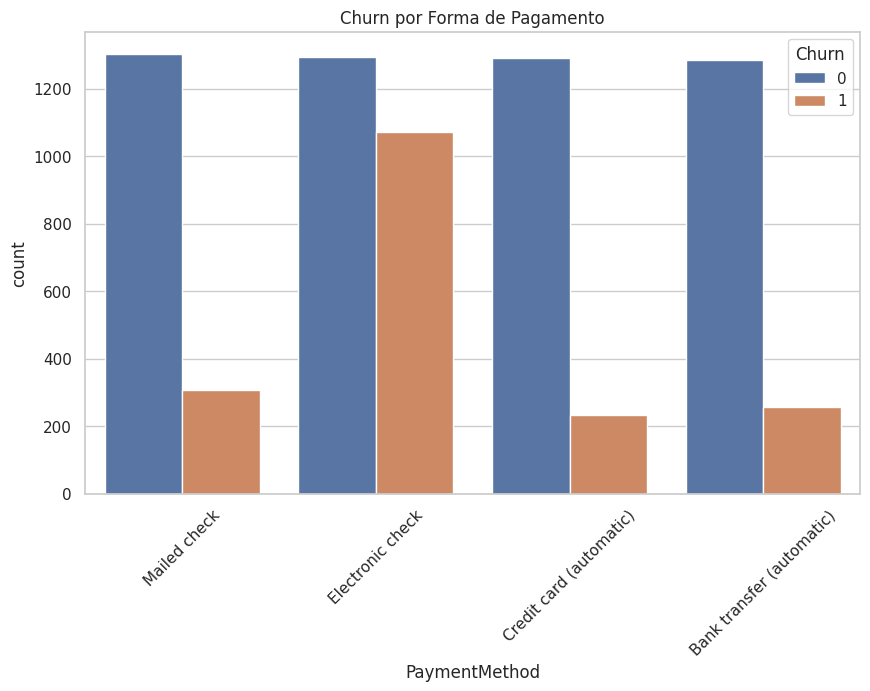


Estatísticas de Tenure por categoria de Churn:
        count       mean        std  min   25%   50%   75%   max
Churn                                                           
0      5174.0  37.569965  24.113777  0.0  15.0  38.0  61.0  72.0
1      1869.0  17.979133  19.531123  1.0   2.0  10.0  29.0  72.0

Valores únicos de Tenure por categoria de Churn:
Churn
0    73
1    72
Name: tenure, dtype: int64

Valores ausentes em Tenure por categoria de Churn:
Churn
0    0
1    0
Name: tenure, dtype: int64


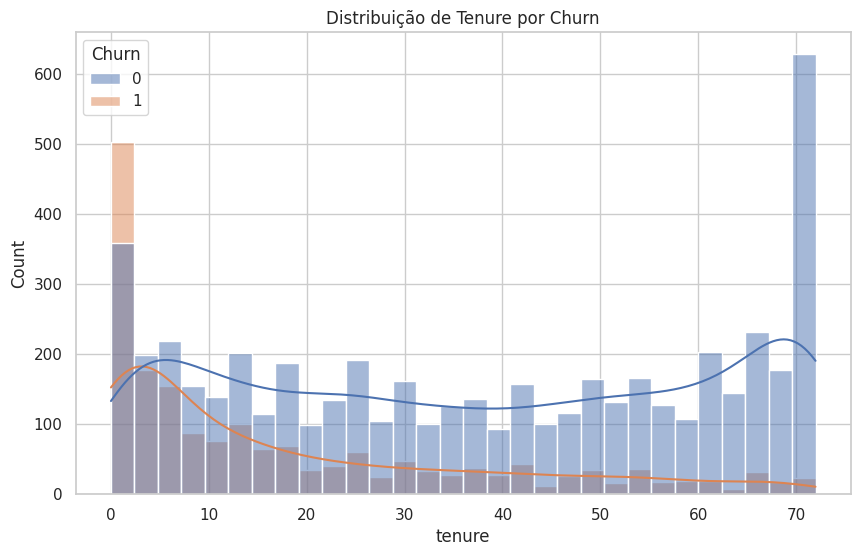

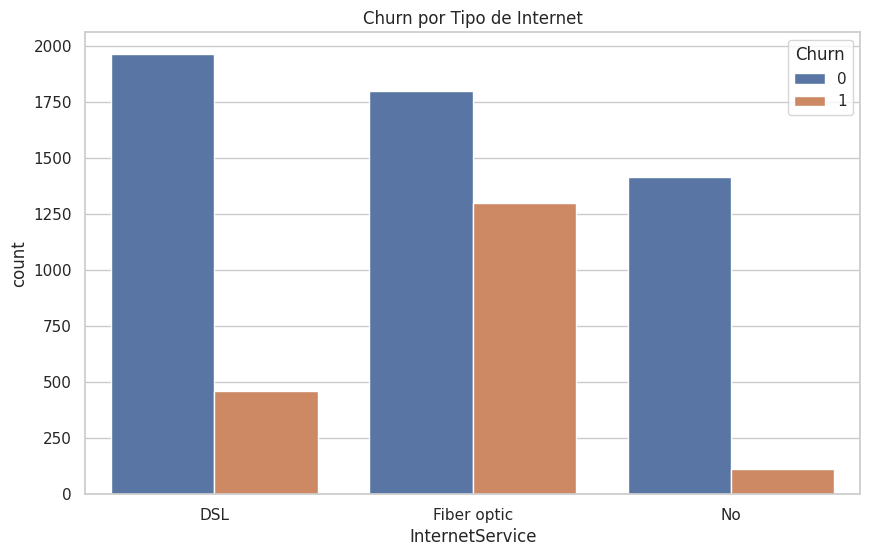

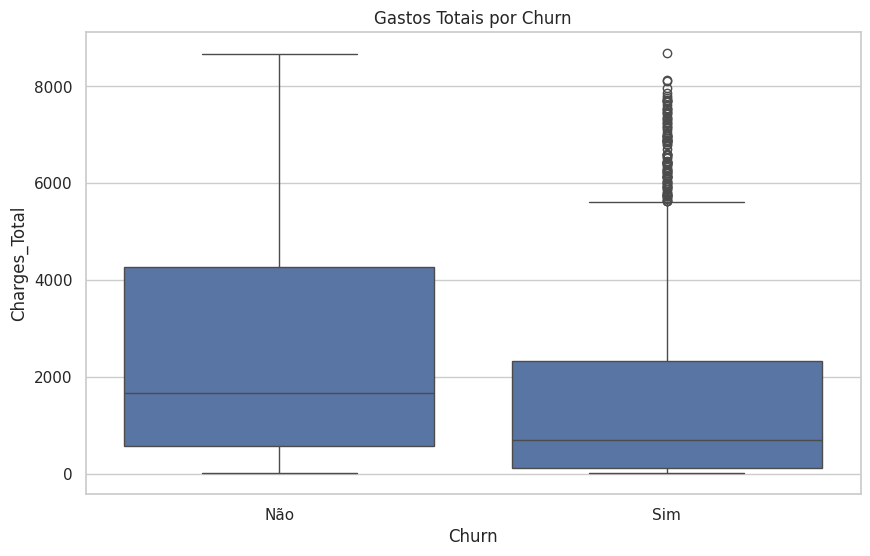

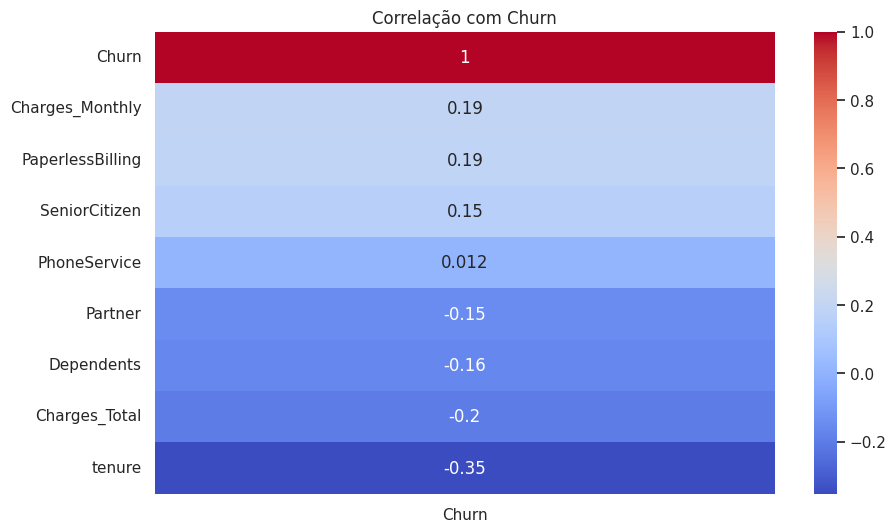

In [15]:
# Converter a coluna 'Churn' para numérica (0 para 'Não' e 1 para 'Sim')
df_final['Churn'] = df_final['Churn'].map({'Yes': 1, 'No': 0})

# Taxa de churn
taxa_churn = df_final['Churn'].mean() * 100
print("Taxa de churn (%):", round(taxa_churn, 2))

# Distribuição de churn
sns.countplot(data=df_final, x='Churn')
plt.title('Distribuição de Churn')
plt.xticks([0, 1], ['Não', 'Sim'])
plt.show()

# Contrato x Churn
sns.countplot(data=df_final, x='Contract', hue='Churn')
plt.title('Churn por Tipo de Contrato')
plt.show()

# Forma de pagamento x Churn
sns.countplot(data=df_final, x='PaymentMethod', hue='Churn')
plt.xticks(rotation=45)
plt.title('Churn por Forma de Pagamento')
plt.show()

# Análise de Tenure
print("\nEstatísticas de Tenure por categoria de Churn:")
print(df_final.groupby('Churn')['tenure'].describe())
print("\nValores únicos de Tenure por categoria de Churn:")
print(df_final.groupby('Churn')['tenure'].nunique())
print("\nValores ausentes em Tenure por categoria de Churn:")
print(df_final.groupby('Churn')['tenure'].apply(lambda x: x.isnull().sum()))

# Distribuição de Tenure
sns.histplot(data=df_final, x='tenure', hue='Churn', bins=30, kde=True)
plt.title('Distribuição de Tenure por Churn')
plt.show()

# Tipo de internet x Churn
sns.countplot(data=df_final, x='InternetService', hue='Churn')
plt.title('Churn por Tipo de Internet')
plt.show()

# Gastos Totais x Churn
sns.boxplot(data=df_final, x='Churn', y='Charges_Total')
plt.title('Gastos Totais por Churn')
plt.xticks([0, 1], ['Não', 'Sim'])
plt.show()

# Correlação com Churn
corr = df_final.corr(numeric_only=True)
sns.heatmap(corr[['Churn']].sort_values(by='Churn', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlação com Churn')
plt.show()


### 📄Relatorio Final

ANALISE E INVESTIGAÇÃO DO CHURN (Principais Achados - INSIGHTS):
 - Cerca de 26% dos clientes abandonaram a empresa;
 -	Contratos mensais são vulneráveis à evasão;
 - Clientes com baixa fidelização (tenure abaixo de 12 meses) são mais voláteis;
 - A falta de serviços adicionais (como suporte técnico ou segurança online) também influencia negativamente;
 - Electronic check como forma de pagamento está fortemente associada a maior evasão;
 - Usuários de internet via Fiber optic são mais voláteis;
 - Alto valor de cobrança mensal não necessariamente aumenta o churn, mas combinado com contratos curtos e cobrança eletrônica, sim.

SUGESTÕES PARA REDUZIR O CHURN (Conclusões):
-	Criar campanhas de fidelização para clientes com menos de 12 meses de contrato.
-	Incentivar planos de contrato anual ou bienal com descontos.
-	Oferecer benefícios ou pacotes promocionais para quem usa pagamento por Electronic check.
-	Estimular o uso de serviços adicionais como segurança online e suporte técnico.
-	Implementar um sistema de alerta precoce para clientes com alta propensão de evasão (com base nos padrões identificados).

